In [1]:
import re
from nltk.collocations import TrigramCollocationFinder

In [2]:
def preprocess_train(text):
    text = text.lower() 
    text = re.sub(' {2}', ' ', text)
    text = re.sub(r'\n', '  ', text)
    text = re.sub(r'[\d%,)•($:]', '', text)             
    return text

In [3]:
from pathlib import Path
carpeta = Path("C:\AI4\PLH\Language-detection")

def preproces_test(text):
    text = preprocess_train(text)
    text = re.split(r'\s{3,}', text.strip())
    text = [f"  {text.strip()}  " for text in text]  # Afegeix dos espais al principi i al final
    return text

#for archivo in carpeta.glob("*_tst.txt"):
'''archivo = carpeta / "deu_tst.txt"
with open(archivo, "r", encoding="utf-8") as f:
    texto = f.read()
    texto = preproces_test(texto)
    print(texto)
    contador_salida = 1
    #for line in texto:
    archivo_salida = carpeta / f"{archivo.stem}_{contador_salida}.txt"
    with archivo_salida.open("w", encoding="utf-8") as f:
        f.write(texto)
        contador_salida += 1'''
        


'archivo = carpeta / "deu_tst.txt"\nwith open(archivo, "r", encoding="utf-8") as f:\n    texto = f.read()\n    texto = preproces_test(texto)\n    print(texto)\n    contador_salida = 1\n    #for line in texto:\n    archivo_salida = carpeta / f"{archivo.stem}_{contador_salida}.txt"\n    with archivo_salida.open("w", encoding="utf-8") as f:\n        f.write(texto)\n        contador_salida += 1'

In [4]:
def find_parameters(text):
    finder = TrigramCollocationFinder.from_words(text)
    dic = {}# Las ci ocurrencias del trigrama es el valor en el diccionario
    N = 0
    for k, v in finder.ngram_fd.items(): # N supongo qu es la suma de todos los valores de las claves del diccionario 
        if v >= 5:
            dic[k] = v
            N += v    #==================================
    B = len(dic)
    return [B, N, dic]
    

In [5]:
from math import log

def lindstone(sentence, c_train, B_train, N_train):
    lamda = 0.05
    prob_acum = 0
    finder = TrigramCollocationFinder.from_words(sentence)

    for n in finder.ngram_fd.items():
        grama = n[0]
        #freq = c_train[grama]
        if grama in c_train:
            freq = c_train[grama]
        else:
            freq = 0  # O un altre valor que tingui sentit
        prob_acum += log(freq + lamda) / (N_train + B_train * lamda)
    return prob_acum

############# hay que desacer el log posteriormente?
############# tenemos que comprobar todos los tests con todos los train de todos los idiomas? SÍ

In [6]:
Param_lang = {}

In [7]:
def train(l1, l2):
    #l1 lista de srings de nombres de ficheros (o direcciones donde se encuentra el fichero, tambien str)
    # l2 lista de nombres de idioma a la que pertenece cada fichero
    # len(l1) == len(l2)
    for i in range(len(l1)):
        with open(l1[i], 'r', encoding='utf-8') as f:
            raw_text = f.read()
        prep_text = preprocess_train(raw_text)
        Param_lang[l2[i]] = find_parameters(prep_text)
        


In [8]:
def predict(test_files):
    #test_files lista de strings de fichero de test
    Files_classified = [None]*len(test_files)
    Files_origin = []
    
    for t in range(len(test_files)):
        with open(test_files[t], 'r', encoding='utf-8') as f:
            raw_test = f.read()

        prep_test = preproces_test(raw_test)
        #sentences = prep_test.split("  ") #suponiendo que funciona que cada oracion esta separada por solo 2 espacios
        D_answer = {}
        Answer = [None]*len(prep_test)
        for s in range(len(prep_test)):
            for k in Param_lang.keys():
                l = Param_lang[k]
                B = l[0]
                N = l[1]
                c = l[2]
                prob = lindstone(prep_test[s], c, B, N)
                D_answer[k] = prob
            Answer[s] = max(D_answer, key=D_answer.get)
            Files_origin.append(test_files[t][:3])
        Files_classified[t] = Answer
    return Files_classified, Files_origin

In [9]:
train_files = ['eng_trn.txt', 'spa_trn.txt', 'fra_trn.txt', 'ita_trn.txt', 'deu_trn.txt', 'nld_trn.txt']
lang_of_train_f = ['eng', 'spa', 'fra', 'ita', 'deu', 'nld']
train(train_files, lang_of_train_f)

In [10]:
test_files =['eng_tst.txt', 'ita_tst.txt', 'fra_tst.txt', 'spa_tst.txt', 'deu_tst.txt', 'nld_tst.txt']
#Class_matrix = predict(test_files)

Accuracy: 0.9610


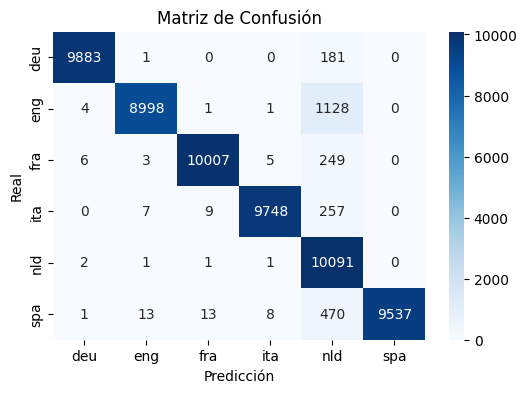

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Files_classified, Files_origin = predict(test_files)

# 1️⃣ Convertimos `Files_classified` (lista de listas) en una sola lista `y_pred`
y_pred = [pred for sublist in Files_classified for pred in sublist]

# 2️⃣ Expandimos `y_true` para que coincida con `y_pred`
y_true = Files_origin

# 3️⃣ Calcular Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 4️⃣ Generar Matriz de Confusión
labels = sorted(set(y_true))  # Ordenar etiquetas únicas
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

# 5️⃣ Visualizar la Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()
